In [2]:
! pip install pymc3

Looking in indexes: https://mirrors.bfsu.edu.cn/pypi/web/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.6/872.6 kB 4.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 43.3 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of pymc3 to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 kB 13.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 12.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 1.7 MB/s eta 0:00:00
  Crea

In [4]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

# 假设我们有一些历史数据
history_time = np.arange(0, 10)  # 历史时间点
history_cost = np.array([80, 75, 72, 69, 68, 66, 67, 70, 74, 78])  # 历史成本
history_price = np.array([120, 118, 115, 110, 105, 100, 95, 90, 88, 85])  # 历史价格

# 定义未来时间
future_time = np.arange(0, 10)

# PyMC v4 模型
with pm.Model() as model:
    # 成本的先验：二次曲线（先降后升）
    alpha_cost = pm.Normal('alpha_cost', mu=0, sigma=10)  # 二次项
    beta_cost = pm.Normal('beta_cost', mu=0, sigma=10)  # 线性项
    gamma_cost = pm.Normal('gamma_cost', mu=70, sigma=10)  # 截距项，表示最低点大约在 70

    # 价格的先验：线性递减
    alpha_price = pm.Normal('alpha_price', mu=-5, sigma=2)  # 线性斜率
    beta_price = pm.Normal('beta_price', mu=120, sigma=10)  # 截距，初始价格

    # 成本模型
    cost_pred = alpha_cost * history_time**2 + beta_cost * history_time + gamma_cost
    # 价格模型
    price_pred = alpha_price * history_time + beta_price

    # 观察数据（历史数据作为观测值）
    cost_obs = pm.Normal('cost_obs', mu=cost_pred, sigma=5, observed=history_cost)
    price_obs = pm.Normal('price_obs', mu=price_pred, sigma=5, observed=history_price)

    # 定义未来的成本和价格预测为 Deterministic 变量
    future_cost_pred = pm.Deterministic('future_cost_pred', alpha_cost * future_time**2 + beta_cost * future_time + gamma_cost)
    future_price_pred = pm.Deterministic('future_price_pred', alpha_price * future_time + beta_price)

    # 后验采样
    trace = pm.sample(2000)




Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_cost, beta_cost, gamma_cost, alpha_price, beta_price]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 42 seconds.


In [2]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Sampling: [cost_obs, price_obs]


Output()

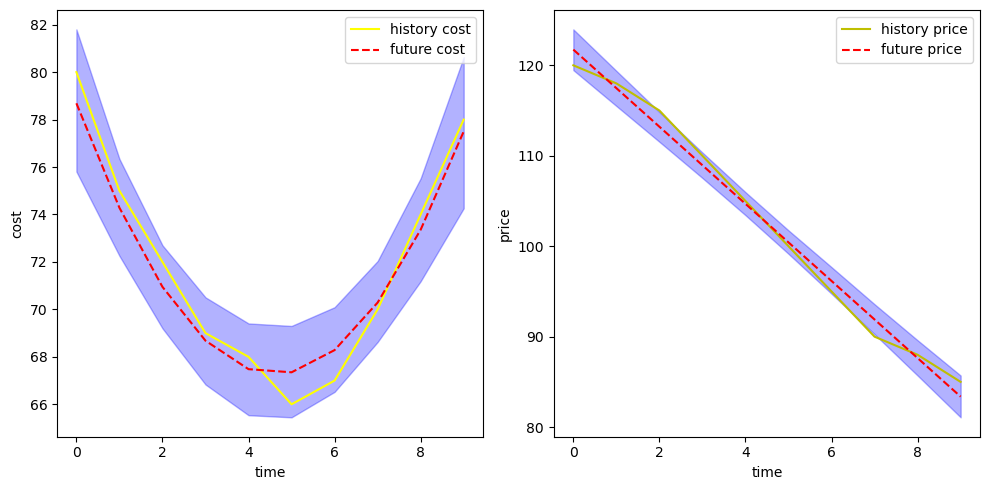

In [6]:
# 使用采样结果来预测未来
with model:
    # 获取未来的预测分布
    posterior_predictive = pm.sample_posterior_predictive(trace)

    # 提取未来的预测数据（从trace中提取）
    future_cost_samples = trace['posterior']['future_cost_pred']
    future_price_samples = trace['posterior']['future_price_pred']

# 预测结果可视化
plt.figure(figsize=(10, 5))

# 画出成本的预测
plt.subplot(1, 2, 1)
plt.plot(history_time, history_cost, 'yellow', label='history cost')
plt.plot(future_time, future_cost_samples.mean(axis=0).mean(axis = 0), 'r--', label='future cost')
plt.fill_between(future_time, 
                 np.percentile(future_cost_samples.mean(axis = 0), 5, axis=0), 
                 np.percentile(future_cost_samples.mean(axis = 0), 95, axis=0), 
                 color='blue', alpha=0.3)
plt.xlabel('time')
plt.ylabel('cost')
plt.legend()

# 画出价格的预测
plt.subplot(1, 2, 2)
plt.plot(history_time, history_price, 'y', label='history price')
plt.plot(future_time, future_price_samples.mean(axis=0).mean(axis = 0), 'r--', label='future price')
plt.fill_between(future_time, 
                 np.percentile(future_price_samples.mean(axis = 0), 5, axis=0), 
                 np.percentile(future_price_samples.mean(axis = 0), 95, axis=0), 
                 color='blue', alpha=0.3)
plt.xlabel('time')
plt.ylabel('price')
plt.legend()

plt.tight_layout()
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_global, beta_global, alpha_0, beta_0, alpha_1, beta_1]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.
/Users/tangning/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/tangning/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/tangning/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/tangning/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


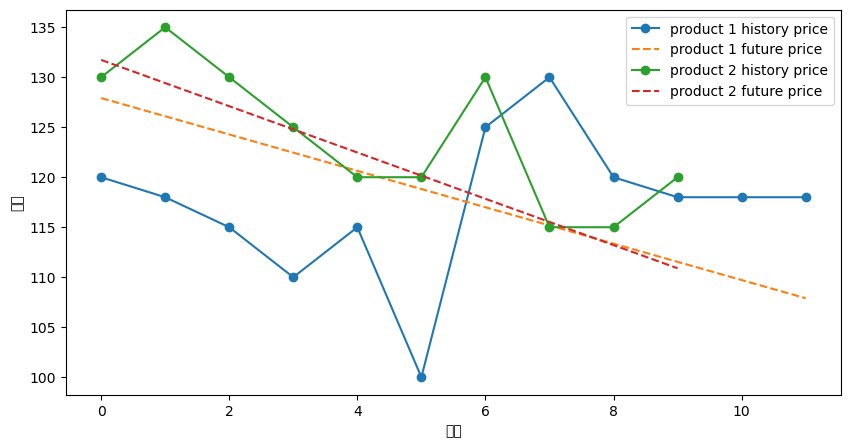

In [13]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

# 假设有两个产品的历史时间和价格记录
history_time_1 = np.arange(0, 12)  # 产品1的时间点
history_price_1 = np.array([120, 118, 115, 110, 115, 100, 125, 130, 120, 118, 118, 118])  # 产品1的价格

history_time_2 = np.arange(0, 10)  # 产品2的时间点
history_price_2 = np.array([130, 135, 130, 125, 120, 120, 130, 115, 115, 120])  # 产品2的价格

# 将不同产品的时间和价格数据存入列表
history_times = [history_time_1, history_time_2]
history_prices = [history_price_1, history_price_2]

# PyMC 分层贝叶斯模型
with pm.Model() as model:
    # 全局先验: 所有产品共享的线性模型先验
    alpha_global = pm.Normal('alpha_global', mu=-3, sigma=2)  # 全局斜率的先验
    beta_global = pm.Normal('beta_global', mu=120, sigma=10)  # 全局截距的先验

    # 为每个产品定义局部参数
    alphas = []  # 每个产品的局部斜率
    betas = []   # 每个产品的局部截距
    for i, (times, prices) in enumerate(zip(history_times, history_prices)):
        alpha_i = pm.Normal(f'alpha_{i}', mu=alpha_global, sigma=1)  # 每个产品的局部斜率
        beta_i = pm.Normal(f'beta_{i}', mu=beta_global, sigma=5)     # 每个产品的局部截距
        alphas.append(alpha_i)
        betas.append(beta_i)

        # 产品 i 的价格预测
        price_pred = alpha_i * times + beta_i
        # 观测噪声：较大的噪声可以减小数据对模型的影响
        price_obs = pm.Normal(f'price_obs_{i}', mu=price_pred, sigma=15, observed=prices)

    # 后验采样
    trace = pm.sample(2000)

# 可视化结果
plt.figure(figsize=(10, 5))

for i, (times, prices) in enumerate(zip(history_times, history_prices)):
    alpha_samples = trace['posterior'][f'alpha_{i}'].values.flatten()
    beta_samples = trace['posterior'][f'beta_{i}'].values.flatten()

    # 计算预测的均值
    predicted_prices_mean = np.mean(alpha_samples[:, None] * times + beta_samples[:, None], axis=0)

    # 画出历史价格和拟合的预测结果
    plt.plot(times, prices, 'o-', label=f'product {i+1} history price')
    plt.plot(times, predicted_prices_mean, '--', label=f'product {i+1} future price')

plt.xlabel('时间')
plt.ylabel('价格')
plt.legend()
plt.show()


In [8]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [11]:
trace['posterior'][f'alpha_{0}'].values.shape

(4, 2000)

In [14]:
! pwd

/Users/tangning/Desktop/DTM/lifecycle_features


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv('./../Dataset/latex_pillow.csv')
df = df[df['Sales_volume'] != 0]
df = df.dropna()
df

,Month,Unit_price,Sales_volume,Revenue,Cost,Promotion_expense,Profit,Version,Unit_cost,ROI,Profit_rate,Target
0,9,231.022793,8599.0,1.986565e+06,513463.73,2.979848e+05,1.175117e+06,1.0,59.712028,1.448171,0.591532,22031.0
1,10,228.190640,22031.0,5.027268e+06,1296847.55,7.540902e+05,2.976330e+06,1.0,58.864670,1.451205,0.592037,57819.0
2,11,235.609903,57819.0,1.362273e+07,3466877.14,2.043409e+06,8.112443e+06,1.0,59.960863,1.472236,0.595508,34354.0
3,12,232.228445,34354.0,7.977976e+06,2038590.83,1.196696e+06,4.742689e+06,1.0,59.340712,1.465925,0.594473,20282.0
4,1,101.821270,20282.0,2.065139e+06,1170602.10,3.097708e+05,5.847661e+05,1.0,57.716305,0.395013,0.283161,51821.0
...,...,...,...,...,...,...,...,...,...,...,...,...
81,6,95.717707,3620.0,3.464981e+05,158197.14,5.197471e+04,1.363262e+05,4.0,43.700867,0.648642,0.393440,2407.0
82,7,92.408766,2407.0,2.224279e+05,119451.71,3.336418e+04,6.961201e+04,4.0,49.626801,0.455529,0.312964,2368.0
83,8,99.675908,2368.0,2.360325e+05,130987.47,3.540488e+04,6.964020e+04,4.0,55.315655,0.418530,0.295045,3459.0
84,9,91.487771,3459.0,3.164562e+05,164136.12,4.746843e+04,1.048516e+05,4.0,47.451899,0.495508,0.331331,2572.0


In [24]:
version2 = df[df['Version'] == 2]
version2['Unit_price'].values


array([123.91701137, 122.82736629, 113.31224963, 111.67599691,
       121.48030185, 121.69909175, 123.88180472, 122.92087785,
       113.44698994, 127.80032001, 127.12794118, 135.80814605])

In [28]:
version3 = df[df['Version'] == 3]
version3['Unit_price'].values
np.mean(version3['Unit_price'].values)


103.2168385081817

In [33]:
version3['Unit_price'].values[:9]

array([136.54532247, 136.01043554, 115.5625149 , 112.42755047,
        71.85146911,  64.0012287 ,  65.36715241,  69.49832794,
        80.39936158])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_global, beta_global, alpha_0, beta_0, alpha_1, beta_1]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 25 seconds.
/Users/tangning/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/tangning/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/tangning/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/tangning/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


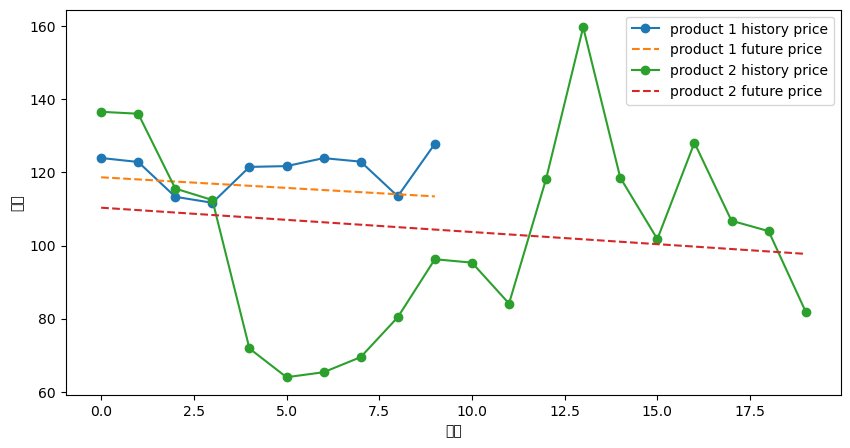

In [34]:
# 假设有两个产品的历史时间和价格记录
history_time_1 = np.arange(0, 10)  # 产品1的时间点
history_price_1 = version2['Unit_price'].values[:10]  # 产品1的价格

history_time_2 = np.arange(0, 20)  # 产品2的时间点
history_price_2 = version3['Unit_price'].values[:20]  # 产品2的价格

# 将不同产品的时间和价格数据存入列表
history_times = [history_time_1, history_time_2]
history_prices = [history_price_1, history_price_2]

# PyMC 分层贝叶斯模型
with pm.Model() as model:
    # 全局先验: 所有产品共享的线性模型先验
    alpha_global = pm.Normal('alpha_global', mu=-4, sigma=1)  # 全局斜率的先验
    beta_global = pm.Normal('beta_global', mu=110, sigma=10)  # 全局截距的先验

    # 为每个产品定义局部参数
    alphas = []  # 每个产品的局部斜率
    betas = []   # 每个产品的局部截距
    for i, (times, prices) in enumerate(zip(history_times, history_prices)):
        alpha_i = pm.Normal(f'alpha_{i}', mu=alpha_global, sigma=1)  # 每个产品的局部斜率
        beta_i = pm.Normal(f'beta_{i}', mu=beta_global, sigma=5)     # 每个产品的局部截距
        alphas.append(alpha_i)
        betas.append(beta_i)

        # 产品 i 的价格预测
        price_pred = alpha_i * times + beta_i
        # 观测噪声：较大的噪声可以减小数据对模型的影响
        price_obs = pm.Normal(f'price_obs_{i}', mu=price_pred, sigma=15, observed=prices)

    # 后验采样
    trace = pm.sample(500)

# 可视化结果
plt.figure(figsize=(10, 5))

for i, (times, prices) in enumerate(zip(history_times, history_prices)):
    alpha_samples = trace['posterior'][f'alpha_{i}'].values.flatten()
    beta_samples = trace['posterior'][f'beta_{i}'].values.flatten()

    # 计算预测的均值
    predicted_prices_mean = np.mean(alpha_samples[:, None] * times + beta_samples[:, None], axis=0)

    # 画出历史价格和拟合的预测结果
    plt.plot(times, prices, 'o-', label=f'product {i+1} history price')
    plt.plot(times, predicted_prices_mean, '--', label=f'product {i+1} future price')

plt.xlabel('时间')
plt.ylabel('价格')
plt.legend()
plt.show()

In [37]:
trace['posterior'][f'alpha_{0}'].values.flatten().shape, trace['posterior'][f'alpha_{1}'].values.flatten()

((2000,),
 array([-0.83195164, -1.24114291, -0.53435342, ..., -0.0950184 ,
        -1.65926214, -0.91978734]))

array([56.38969016, 56.37820945, 51.42673119, 49.85145793, 56.80647616,
       55.17738917, 56.20198734, 55.58315352, 48.65993659, 56.45115607,
       55.91537647, 55.14510889])

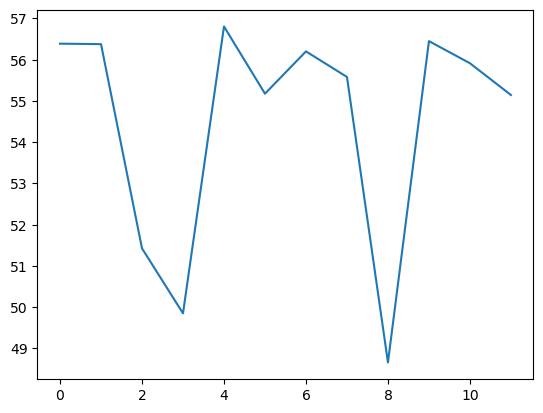

In [39]:
plt.plot(version2['Unit_cost'].values)
version2['Unit_cost'].values

array([55.7660659 , 57.00991654, 47.38039189, 47.32374028, 44.34669565,
       41.02620336, 41.45450108, 42.03993617, 43.30548339, 46.89522087,
       46.61255555, 44.32044994, 44.5044001 , 44.59460687, 46.61633889,
       45.84514121, 45.4568258 , 46.04351606, 44.86618053, 45.53773099,
       42.97896136, 46.28194906, 46.79948866])

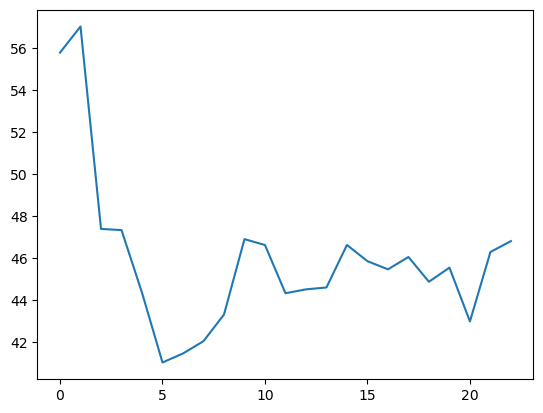

In [40]:
plt.plot(version3['Unit_cost'].values)
version3['Unit_cost'].values


In [43]:
# 假设我们有一些历史数据
history_time = np.arange(0, 23)  # 历史时间点
history_cost = version3['Unit_cost'].values  # 历史成本

# 定义未来时间
future_time = np.arange(0, 20)

# PyMC v4 模型
with pm.Model() as model:
    # 成本的先验：二次曲线（先降后升）
    alpha_cost = pm.Normal('alpha_cost', mu=0, sigma=10)  # 二次项
    beta_cost = pm.Normal('beta_cost', mu=0, sigma=10)  # 线性项
    gamma_cost = pm.Normal('gamma_cost', mu=70, sigma=10)  # 截距项，表示最低点大约在 70


    cost_pred = alpha_cost * history_time**2 + beta_cost * history_time + gamma_cost

    # 观察数据（历史数据作为观测值）
    cost_obs = pm.Normal('cost_obs', mu=cost_pred, sigma=5, observed=history_cost)
    

    # 定义未来的成本和价格预测为 Deterministic 变量
    future_cost_pred = pm.Deterministic('future_cost_pred', alpha_cost * future_time**2 + beta_cost * future_time + gamma_cost)

    # 后验采样
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_cost, beta_cost, gamma_cost]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 29 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [cost_obs]


Output()

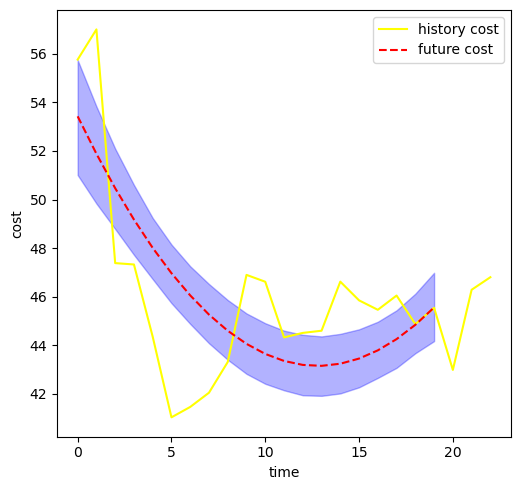

In [44]:
with model:
    # 获取未来的预测分布
    posterior_predictive = pm.sample_posterior_predictive(trace)

    # 提取未来的预测数据（从trace中提取）
    future_cost_samples = trace['posterior']['future_cost_pred']


# 预测结果可视化
plt.figure(figsize=(10, 5))

# 画出成本的预测
plt.subplot(1, 2, 1)
plt.plot(history_time, history_cost, 'yellow', label='history cost')
plt.plot(future_time, future_cost_samples.mean(axis=0).mean(axis = 0), 'r--', label='future cost')
plt.fill_between(future_time, 
                 np.percentile(future_cost_samples.mean(axis = 0), 5, axis=0), 
                 np.percentile(future_cost_samples.mean(axis = 0), 95, axis=0), 
                 color='blue', alpha=0.3)
plt.xlabel('time')
plt.ylabel('cost')
plt.legend()


plt.tight_layout()
plt.show()